# **Sales Price Prediction ML Noteboook**

## Objectives

* To train a ML pipeline using turning with the best features to predicts the sale price of a property.
* Answer *Businesss Requirement 2*:
    * The client is interested in predicting the house sale price from her four inherited houses and any other house in Ames, Iowa.

## Inputs

* <code>outputs/datasets/cleaned/HousePriceRecordsCleaned.csv</code>
* Using the variables highlighed in both *Data Cleaning* and *Feature Engineering* Notebooks

## Outputs

* <code>TrainSet</code>
* <code>TestSet</code>
* ML pipeline to predict property price sales
* Feature importance plot
* Model performance plot

## Additional Comments 

* Define a pipeline
* Find the best model
* Run a PCA analysis 


---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/heritage-housing-issues/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/heritage-housing-issues'

---

# Load Cleaned Data

We want to load the cleaned *House Price Records Dataset*:

In [4]:
import pandas as pd
df = pd.read_csv("outputs/datasets/cleaned/HousePriceRecordsCleaned.csv")
print(df.shape)
df.head()

(1460, 22)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,548,RFn,2003.0,...,8450,65.0,196.0,61,5,7,856,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,460,RFn,1976.0,...,9600,80.0,0.0,0,8,6,1262,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,608,RFn,2001.0,...,11250,68.0,162.0,42,5,7,920,2001,2002,223500
3,961,0.0,3.0,No,216,ALQ,540,642,Unf,1998.0,...,9550,60.0,0.0,35,5,7,756,1915,1970,140000
4,1145,0.0,4.0,Av,655,GLQ,490,836,RFn,2000.0,...,14260,84.0,350.0,84,5,8,1145,2000,2000,250000


---

# ML Regressor Pipeline

Next we create the pipeline, using the data collected from the *Data Cleaning* and *Feature Engineering Notebooks*:

In [5]:
from sklearn.pipeline import Pipeline

### Data Cleaning
from feature_engine.selection import DropFeatures
from feature_engine.imputation import CategoricalImputer
from feature_engine.imputation import ArbitraryNumberImputer
from feature_engine.imputation import MeanMedianImputer

### Feature Engineering
from feature_engine import transformation as vt
from feature_engine.encoding import OrdinalEncoder
from feature_engine.outliers import Winsorizer
from feature_engine.selection import SmartCorrelatedSelection

### Feat Scaling
from sklearn.preprocessing import StandardScaler

### Feat Selection
from sklearn.feature_selection import SelectFromModel

### ML algorithms
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

### Data Cleaning
dc_categorical_features = ['GarageFinish', 'BsmtFinType1', 'BsmtExposure']
dc_arbitrary_features = ['MasVnrArea']
dc_median_features = ['LotFrontage', 'BedroomAbvGr']

### Feature Engineering
fe_categorical_vars = ['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']
fe_log_transformer_vars = ['1stFlrSF', 'GrLivArea', 'LotArea']
fe_power_transformer_vars = ['MasVnrArea']
fe_yeo_transformer_vars = ['OpenPorchSF']


dropped_features = ['2ndFlrSF', 'GarageYrBlt', 'TotalBsmtSF', 'YearRemodAdd']

def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ('DropFeatures', DropFeatures(features_to_drop=dropped_features)),
        
        ('CategoricalImputer', CategoricalImputer(imputation_method='frequent', variables=dc_categorical_features)),

        ('ArbitraryNumberImputer', ArbitraryNumberImputer(arbitrary_number=0, variables=dc_arbitrary_features)),

        ('MeanMedianImputer', MeanMedianImputer(imputation_method='median', variables=dc_median_features)),

        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary', variables=fe_categorical_vars)),

        ("NumericLogTransform", vt.LogTransformer(variables=fe_log_transformer_vars)),
        
        ("NumericPowerTransform", vt.PowerTransformer(variables=fe_power_transformer_vars)),
        
        ("NumericYeoJohnsonTransform", vt.YeoJohnsonTransformer(variables=fe_yeo_transformer_vars)),

        ('WinsorizerIQR', Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=['1stFlrSF', 'GrLivArea','BsmtFinSF1', 'BsmtUnfSF', 
                    'GarageArea', 'LotArea', 'LotFrontage', 'MasVnrArea'])),

        ("feat_scaling", StandardScaler()),
        
        ("feat_selection",  SelectFromModel(model)),
        
        ("model", model),

    ])

    return pipeline_base

Next we create a *custom class* for *hyperparameter optimisation*:

In [6]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches

### Split Train and Test Sets

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 21) (1168,) 
* Test set: (292, 21) (292,)


---

# Grid Search CV - Sklean

Next we use default hyperparameters to find the most suitable algorithm to use:

In [8]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

Then we conduct the search using these default hyperparameters:

In [9]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Afterwards we check the results:

In [10]:
import numpy as np
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
3,ExtraTreesRegressor,0.712896,0.813475,0.859056,0.052263
0,LinearRegression,0.729746,0.791724,0.848295,0.044267
4,AdaBoostRegressor,0.656684,0.736431,0.780689,0.047382
2,RandomForestRegressor,0.663645,0.733421,0.801993,0.055154
5,GradientBoostingRegressor,0.581155,0.727939,0.796152,0.07778
6,XGBRegressor,0.640632,0.677611,0.711843,0.02644
1,DecisionTreeRegressor,0.495809,0.57921,0.667303,0.067188


#### Findings:

* Reaches the clients requirement of an *R2* score of at least 0.75
* The best result shows as: <code>ExtraTreeRegressor</code> with an average *R2* score of around 0.81
* Next we will apply an extensive search in hopes to improve this score

### Extensive Search on Most Suitable Model

Next we will perform an extensive search on the <code>ExtraTreeRegressor</code>:

In [11]:
models_search = {
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
}

params_search = {
    "ExtraTreesRegressor":{'model__n_estimators': [50,100,150],
        'model__max_depth': [None, 3, 15],
        'model__min_samples_split': [2, 50],
        'model__min_samples_leaf': [1,50],
        },
}

In [12]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [13]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__min_samples_leaf,model__min_samples_split,model__n_estimators
1,ExtraTreesRegressor,0.712896,0.813475,0.859056,0.052263,None,1,2,100
26,ExtraTreesRegressor,0.706445,0.812519,0.862407,0.055013,15,1,2,150
25,ExtraTreesRegressor,0.707444,0.812241,0.862954,0.054647,15,1,2,100
2,ExtraTreesRegressor,0.709729,0.81146,0.862452,0.053696,None,1,2,150
24,ExtraTreesRegressor,0.704076,0.810911,0.855637,0.054942,15,1,2,50
28,ExtraTreesRegressor,0.762105,0.810331,0.851013,0.037075,15,1,50,100
4,ExtraTreesRegressor,0.762105,0.810328,0.851028,0.037073,None,1,50,100
27,ExtraTreesRegressor,0.762726,0.809593,0.851766,0.037848,15,1,50,50
3,ExtraTreesRegressor,0.762726,0.809569,0.851705,0.037826,None,1,50,50
29,ExtraTreesRegressor,0.760651,0.808739,0.849882,0.037073,15,1,50,150


#### Findings:

* Extensive search also meets requirement
* Further parameters show the best model to use

### Establishing The Best Model

In [14]:
best_model = grid_search_summary.iloc[0,0]
best_model

'ExtraTreesRegressor'

In [15]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__max_depth': None,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 100}

In [16]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('DropFeatures',
                 DropFeatures(features_to_drop=['2ndFlrSF', 'GarageYrBlt',
                                                'TotalBsmtSF',
                                                'YearRemodAdd'])),
                ('CategoricalImputer',
                 CategoricalImputer(imputation_method='frequent',
                                    variables=['GarageFinish', 'BsmtFinType1',
                                               'BsmtExposure'])),
                ('ArbitraryNumberImputer',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['MasVnrArea'])),
                ('Mean...
                 YeoJohnsonTransformer(variables=['OpenPorchSF'])),
                ('WinsorizerIQR',
                 Winsorizer(capping_method='iqr', fold=1.5, tail='both',
                            variables=['1stFlrSF', 'GrLivArea', 'BsmtFinSF1',
                                       'BsmtUnfSF', 'GarageArea', 'LotArea',
                                       'LotFrontage', 'MasVnrArea'])),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=ExtraTreesRegressor(random_state=0))),
                ('model', ExtraTreesRegressor(random_state=0))])

---

# Assess Feature Importance

Next we assess the *feature importance*:

* These are the 5 most important features in descending order. The model was trained on them: 
['1stFlrSF', 'GarageArea', 'GrLivArea', 'OverallQual', 'YearBuilt']


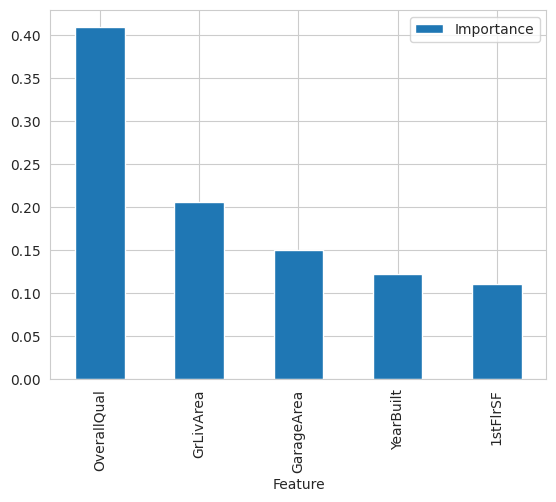

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

%matplotlib inline

data_cleaning_feat_eng_steps = 9 
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
          'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
          'Importance': best_regressor_pipeline['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{best_features}")

df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.show()

### Findings

* These are the 5 most important features in descending order, the model was trained on them: 
    * <code>['1stFlrSF', 'GarageArea', 'GrLivArea', 'OverallQual', 'YearBuilt']</code>

### Evaluate on Train and Test Sets

In [18]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error 
import numpy as np

def regression_performance(X_train, y_train, X_test, y_test,pipeline):
	print("Model Evaluation \n")
	print("* Train Set")
	regression_evaluation(X_train,y_train,pipeline)
	print("* Test Set")
	regression_evaluation(X_test,y_test,pipeline)

def regression_evaluation(X,y,pipeline):
  prediction = pipeline.predict(X)
  print('R2 Score:', r2_score(y, prediction).round(3))  
  print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))  
  print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))  
  print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y, prediction)).round(3))
  print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test,pipeline, alpha_scatter=0.5):
  pred_train = pipeline.predict(X_train)
  pred_test = pipeline.predict(X_test)


  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
  sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
  sns.lineplot(x=y_train , y=y_train, color='red', ax=axes[0])
  axes[0].set_xlabel("Actual")
  axes[0].set_ylabel("Predictions")
  axes[0].set_title("Train Set")

  sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
  sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
  axes[1].set_xlabel("Actual")
  axes[1].set_ylabel("Predictions")
  axes[1].set_title("Test Set")
  plt.show()

The goals of the prediction: The client agreed with an *R2* score of at least 0.75 on both <code>Train</code> and <code>Test</code> sets:

Model Evaluation 

* Train Set
R2 Score: 1.0
Mean Absolute Error: 164.487
Mean Squared Error: 1114697.857
Root Mean Squared Error: 1055.793


* Test Set
R2 Score: 0.866
Mean Absolute Error: 20026.107
Mean Squared Error: 923471688.204
Root Mean Squared Error: 30388.677




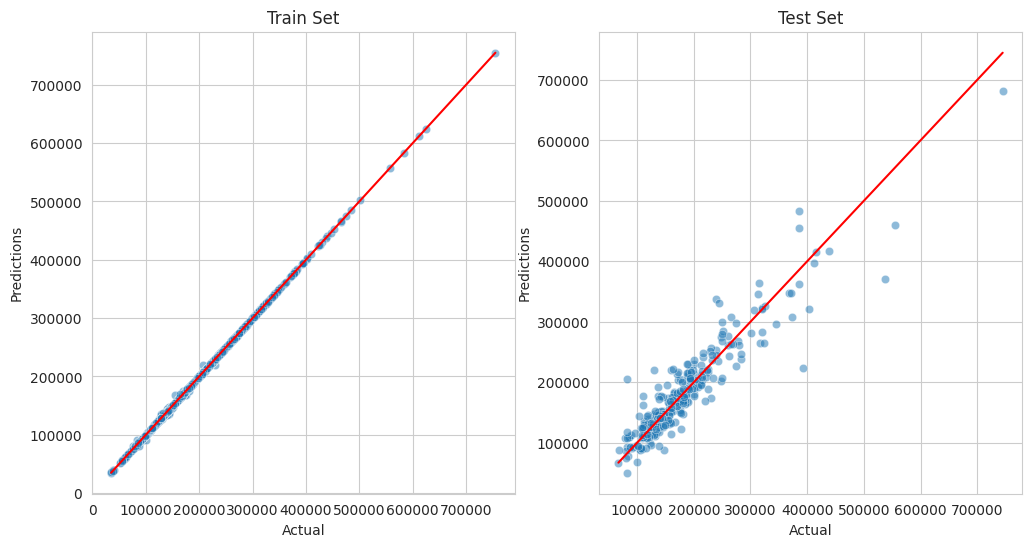

In [19]:
regression_performance(X_train, y_train, X_test, y_test,best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

#### Findings

* <code>Train</code>set:
    * Meet the requirements with an *R2* score of exactly 1.0
* <code>Test</code>set:
    * Meet the requirements with an *R2* score of 0.86

## Applying Regressor with Prinicipal Component Analysis

Next we will explore any potentail values for <code>PCA n_componetns</code>:

In [20]:
pipeline = PipelineOptimization(model=LinearRegression())
pipeline_pca = Pipeline(pipeline.steps[:9])
df_pca = pipeline_pca.fit_transform(df.drop(['SalePrice'],axis=1))

print(df_pca.shape,'\n', type(df_pca))

(1460, 17) 
 <class 'pandas.core.frame.DataFrame'>


Next we apply the *PCA* to the scaled data:

* The 17 components explain 100.0% of the data 



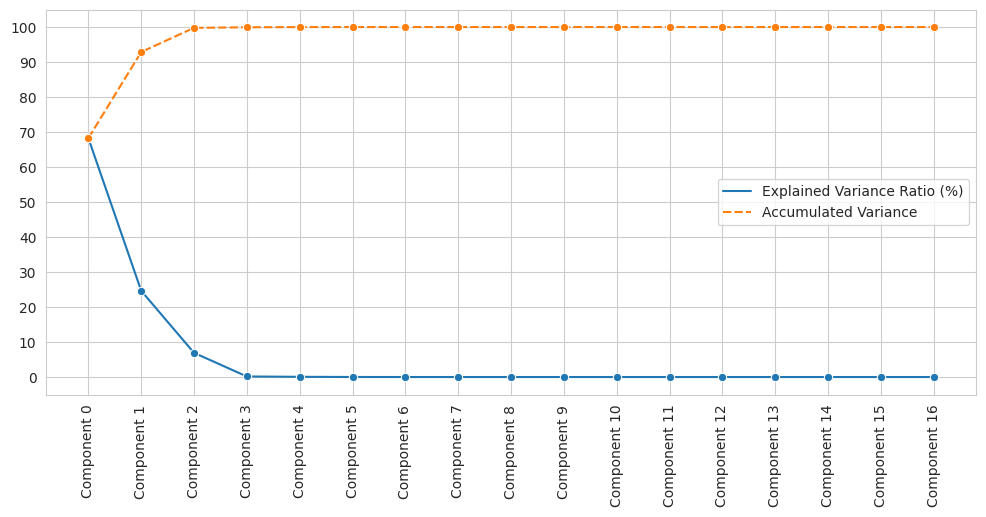

In [21]:
import numpy as np
from sklearn.decomposition import PCA

n_components = 17


def pca_components_analysis(df_pca, n_components):
    pca = PCA(n_components=n_components).fit(df_pca)
    x_PCA = pca.transform(df_pca)  # array with transformed PCA

    ComponentsList = ["Component " + str(number)
                      for number in range(n_components)]
    dfExplVarRatio = pd.DataFrame(
        data=np.round(100 * pca.explained_variance_ratio_, 3),
        index=ComponentsList,
        columns=['Explained Variance Ratio (%)'])

    dfExplVarRatio['Accumulated Variance'] = dfExplVarRatio['Explained Variance Ratio (%)'].cumsum(
    )

    PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum(
    )

    print(
        f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=dfExplVarRatio,  marker="o")
    plt.xticks(rotation=90)
    plt.yticks(np.arange(0, 110, 10))
    plt.show()


pca_components_analysis(df_pca=df_pca, n_components=n_components)

* The 4 components explain 99.93% of the data 



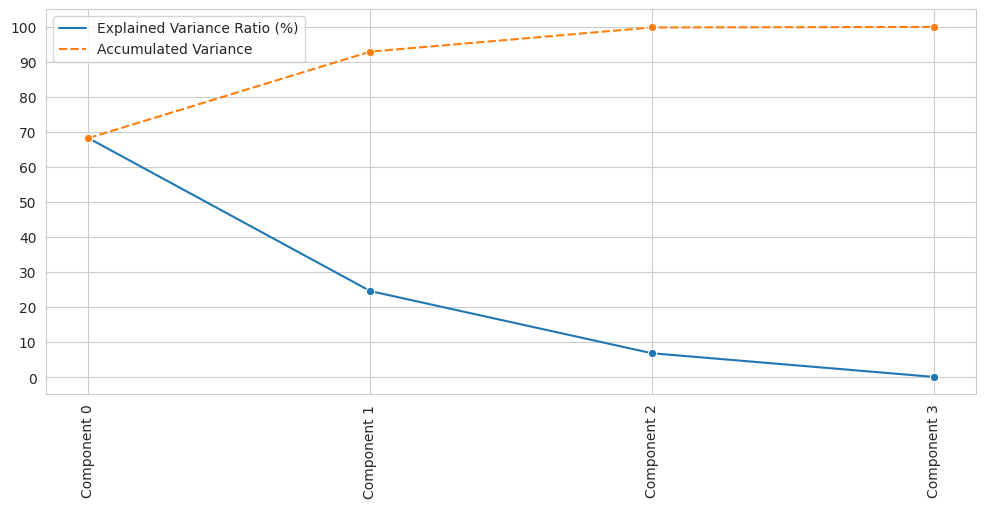

In [22]:
n_components = 4
pca_components_analysis(df_pca=df_pca,n_components=n_components)

#### Findings

* We can see that even by removing some of the components, the majority of the data will still be explained

## Rewrite ML Pipeline for Modelling using PCA

Next we will rewrite the pipeline, the *PCA* step replaces the *feature selection* step:

In [23]:
### Data Cleaning
dc_categorical_features = ['GarageFinish', 'BsmtFinType1', 'BsmtExposure']
dc_arbitrary_features = ['MasVnrArea']
dc_median_features = ['LotFrontage', 'BedroomAbvGr']

### Feature Engineering
fe_categorical_vars = ['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']
fe_log_transformer_vars = ['1stFlrSF', 'GrLivArea', 'LotArea']
fe_power_transformer_vars = ['MasVnrArea']
fe_yeo_transformer_vars = ['OpenPorchSF']


dropped_features = ['2ndFlrSF', 'GarageYrBlt', 'TotalBsmtSF', 'YearRemodAdd']

def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ('DropFeatures', DropFeatures(features_to_drop=dropped_features)),
        
        ('CategoricalImputer', CategoricalImputer(imputation_method='frequent', variables=dc_categorical_features)),

        ('ArbitraryNumberImputer', ArbitraryNumberImputer(arbitrary_number=0, variables=dc_arbitrary_features)),

        ('MeanMedianImputer', MeanMedianImputer(imputation_method='median', variables=dc_median_features)),

        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary', variables=fe_categorical_vars)),

        ("NumericLogTransform", vt.LogTransformer(variables=fe_log_transformer_vars)),
        
        ("NumericPowerTransform", vt.PowerTransformer(variables=fe_power_transformer_vars)),
        
        ("NumericYeoJohnsonTransform", vt.YeoJohnsonTransformer(variables=fe_yeo_transformer_vars)),

        ('WinsorizerIQR', Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=['1stFlrSF', 'GrLivArea','BsmtFinSF1', 'BsmtUnfSF', 
                    'GarageArea', 'LotArea', 'LotFrontage', 'MasVnrArea'])),

        ("feat_scaling", StandardScaler()),
        
        ("PCA",  PCA(n_components=4, random_state=0)),
        
        ("model", model),

    ])

    return pipeline_base

Then we will repeat the *GridSearch* steps:

In [24]:
print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 21) (1168,) 
* Test set: (292, 21) (292,)


In [25]:
models_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

In [26]:
quick_search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
quick_search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [27]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
2,RandomForestRegressor,0.681995,0.792135,0.856762,0.058639
5,GradientBoostingRegressor,0.668744,0.787968,0.851374,0.063315
3,ExtraTreesRegressor,0.615392,0.779861,0.866478,0.085541
4,AdaBoostRegressor,0.591129,0.74826,0.802599,0.079679
0,LinearRegression,0.692852,0.740054,0.79394,0.040163
6,XGBRegressor,0.659444,0.726105,0.784449,0.049899
1,DecisionTreeRegressor,0.407886,0.62809,0.700795,0.110849


#### Findings

* From the results, the *PCA Analysis* did not result to a better performance of the *model pipeline* overall, and we will therefore be using the pipeline that includes using the *feature selection* as the search determined the best hyperparameters.
* The *PCA Analysis* showed that the best model to use would be a <code>GradientBoostingRegressor</code>, however this did not improve the inital *R2* score. 
* *PCA Analysis R2* score: 0.80
* *Feature Selection R2*: 0.81

---

# Refit the Best Pipeline with Best Features

### Rewrite Pipeline with Best Model

We will now refit the pipeline using the *best features* only, and in theory, this should give the same result as using all the variables:

In [28]:
best_features

['1stFlrSF', 'GarageArea', 'GrLivArea', 'OverallQual', 'YearBuilt']

We remove all the steps we do not require, leaving only the *FeatureEngineering* remaining compared to *best features*:

In [29]:
### Feature Engineering
fe_log_transformer_vars = ['1stFlrSF', 'GrLivArea']

def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ("NumericLogTransform", vt.LogTransformer(variables=fe_log_transformer_vars)),

        ('WinsorizerIQR', Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=['1stFlrSF', 'GrLivArea', 'GarageArea'])),

        ("feat_scaling", StandardScaler() ),

        ('model', ExtraTreesRegressor(max_depth=None, min_samples_split=2, min_samples_leaf=1,
                                     n_estimators=100, random_state=0))])

    return pipeline_base

### Split Train and Test Sets with Best Features

In [30]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
X_train.head(5)

(1168, 5) (1168,) (292, 5) (292,)


,1stFlrSF,GarageArea,GrLivArea,OverallQual,YearBuilt
618,1828,774,1828,9,2007
870,894,308,894,5,1962
92,964,432,964,5,1921
817,1689,857,1689,8,2002
302,1541,843,1541,7,2001


### Grid Search CV: Sklearn

Next we will reload the best *model* and *parameters*:

In [31]:
best_model

'ExtraTreesRegressor'

In [32]:
best_parameters

{'model__max_depth': None,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 100}

We perform another search:

In [33]:
models_search = {
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
}

params_search = {
    "ExtraTreesRegressor":{'model__n_estimators': [50,100,150],
        'model__max_depth': [None, 3, 15],
        'model__min_samples_split': [2, 50],
        'model__min_samples_leaf': [1,50],
        },
}

In [34]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [35]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__min_samples_leaf,model__min_samples_split,model__n_estimators
1,ExtraTreesRegressor,0.712896,0.81937,0.859056,0.054157,None,1,2,100
2,ExtraTreesRegressor,0.709729,0.81826,0.862452,0.055734,None,1,2,150
26,ExtraTreesRegressor,0.706445,0.816421,0.862407,0.056305,15,1,2,150
25,ExtraTreesRegressor,0.707444,0.816074,0.862954,0.055799,15,1,2,100
0,ExtraTreesRegressor,0.688303,0.815045,0.853755,0.063902,None,1,2,50
24,ExtraTreesRegressor,0.704076,0.81441,0.855637,0.056161,15,1,2,50
4,ExtraTreesRegressor,0.762105,0.811164,0.851028,0.037631,None,1,50,100
28,ExtraTreesRegressor,0.762105,0.811158,0.851013,0.037625,15,1,50,100
27,ExtraTreesRegressor,0.762726,0.81055,0.851766,0.038459,15,1,50,50
3,ExtraTreesRegressor,0.762726,0.810526,0.851705,0.038438,None,1,50,50


#### Findings

* We can see that the the *R2* score is still 0.81 and matches the previous pipeline for <code>ExtraTreeRegressor</code>
* *R2* still meets client requirements

Next we will define the best pipeline:

In [36]:
best_pipeline_regressor = grid_search_pipelines[best_model].best_estimator_
best_pipeline_regressor

Pipeline(steps=[('NumericLogTransform',
                 LogTransformer(variables=['1stFlrSF', 'GrLivArea'])),
                ('WinsorizerIQR',
                 Winsorizer(capping_method='iqr', fold=1.5, tail='both',
                            variables=['1stFlrSF', 'GrLivArea', 'GarageArea'])),
                ('feat_scaling', StandardScaler()),
                ('model', ExtraTreesRegressor(random_state=0))])

---

# Push files to Repo

Next we will save the files:

In [37]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/sale_price_prediction/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

### Train Set: Features & Target

In [38]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [39]:
y_train.head()

618    314813
870    109500
92     163500
817    271000
302    205000
Name: SalePrice, dtype: int64

In [40]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

### Test Set: Features & Target

In [41]:
X_test.head()

,1stFlrSF,GarageArea,GrLivArea,OverallQual,YearBuilt
529,2515,484,2515,6,1957
491,958,240,1578,6,1941
459,979,352,1203,5,1950
279,1156,505,2022,7,1977
655,525,264,1092,6,1971


In [42]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [43]:
y_test.head()

529    200624
491    133000
459    110000
279    192000
655     88000
Name: SalePrice, dtype: int64

In [44]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

### Model Pipeline

In [45]:
best_pipeline_regressor

Pipeline(steps=[('NumericLogTransform',
                 LogTransformer(variables=['1stFlrSF', 'GrLivArea'])),
                ('WinsorizerIQR',
                 Winsorizer(capping_method='iqr', fold=1.5, tail='both',
                            variables=['1stFlrSF', 'GrLivArea', 'GarageArea'])),
                ('feat_scaling', StandardScaler()),
                ('model', ExtraTreesRegressor(random_state=0))])

In [46]:
joblib.dump(value=best_pipeline_regressor, filename=f"{file_path}/regression_pipeline.pkl")

['outputs/ml_pipeline/sale_price_prediction/v1/regression_pipeline.pkl']

### Feature Importance Plot

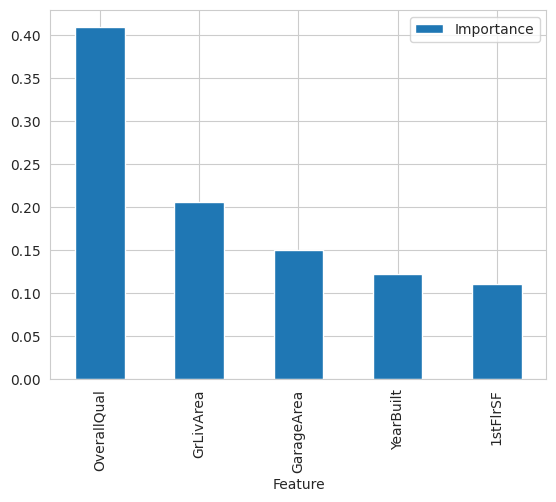

In [47]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

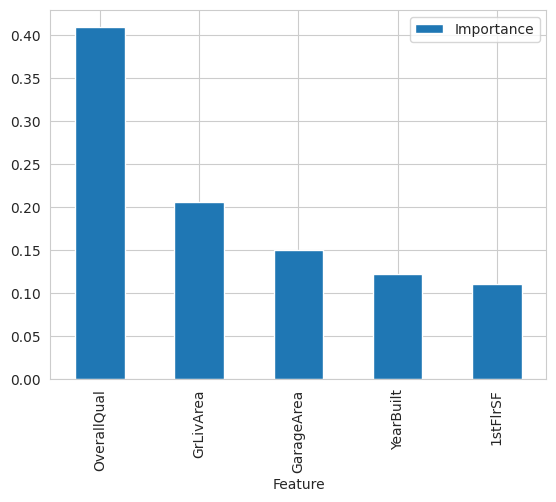

In [48]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.savefig(f'{file_path}/feature_importance.png', bbox_inches='tight')

---

# Conclusions

* A pipeline was created for the *best features*
* The plot for *best features* shows that variables that have a relation to: size, quality, and age of the property have a high predictive power

* From the hypothesis we can conclude that:
    * The size of the property does matter: <code>['GrLivArea', 'GarageArea', '1stFlrSF']</code>, this was also true in the correlation study.
    * The quality of the property plays a huge factor: <code>['OverallQual']</code>, this was also true in the correlation study.
    * That the time is important: <code>['YearBuilt]</code>, this was also true in the correlation study.

---